# classifications avec TF

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
import numpy as np


# Vérifier la version de TensorFlow
print(f"TensorFlow version: {tf.__version__}")



2025-03-06 19:43:09.015583: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-06 19:43:09.470175: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-06 19:43:09.470308: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-06 19:43:09.565141: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-06 19:43:09.743919: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-06 19:43:09.746034: I tensorflow/core/platform/cpu_feature_guard.cc:1

TensorFlow version: 2.15.0


Shape des données d'entraînement: (1000, 64, 64)
Shape des données de test: (200, 64, 64)


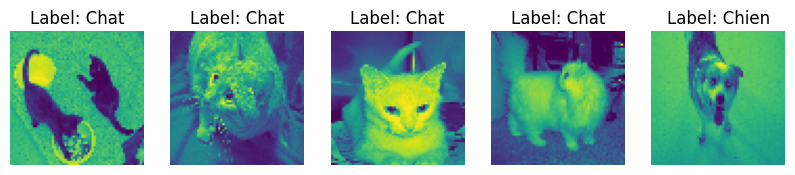

In [104]:
# pour le premier dataset (format h5py)
from utilities import *
X_train, y_train, X_test, y_test = load_data()

# Normalisation des données
X_train = X_train / 255.0
X_test = X_test / 255.0

# Affichage de quelques informations sur les données
print(f"Shape des données d'entraînement: {X_train.shape}")
print(f"Shape des données de test: {X_test.shape}")

# Visualisation de quelques images
plt.figure(figsize=(10, 4))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(X_train[i])
    plt.title(f"Label: {'Chat' if y_train[i] == 0 else 'Chien'}")
    plt.axis('off')
plt.show()


In [3]:
if len(X_train.shape) == 3:
    X_train = X_train[..., np.newaxis]  # Ajoute un canal pour les images en niveaux de gris
    X_test = X_test[..., np.newaxis]
# Affichons la forme de nos données
print("Forme de X_train:", X_train.shape)

NameError: name 'X_train' is not defined

In [4]:
#exercice de pré processing pour préparer mes images
#test sur une image d'abord
from PIL import Image
from numpy import asarray
image = Image.open('dataset/training_set/cats/cat.2.jpg')

img_matrix = asarray(image)
 
# summarize some details about the image
print(image.format)
print(image.size)
print(image.mode)

print(img_matrix.shape) #c'est la shape RGB ou pas? jsuis pas sur (353, 405, 3)

JPEG
(312, 396)
RGB
(396, 312, 3)


In [5]:
import os
from tqdm import tqdm  # Pour afficher une barre de progression

def charger_dataset(dossier_base, taille=(128, 128)):
    categories = ['cats', 'dogs']  # Vos sous-dossiers
    X = []  # Pour stocker les images
    y = []  # Pour stocker les étiquettes (0: chat, 1: chien)
    
    for idx, categorie in enumerate(categories):
        chemin_categorie = os.path.join(dossier_base, categorie)
        print(f"Chargement des images de {categorie}...")
        
        # Liste tous les fichiers dans le dossier
        fichiers = os.listdir(chemin_categorie)
        
        # Parcours avec barre de progression
        for fichier in tqdm(fichiers):
            if fichier.endswith(('.jpg', '.jpeg', '.png')):
                chemin_image = os.path.join(chemin_categorie, fichier)
                
                try:
                    # Ouvrir l'image
                    image = Image.open(chemin_image)
                    
                    # Redimensionner
                    image = image.resize(taille)
                    
                    # Convertir en array numpy
                    image_array = np.array(image)
                    
                    # Vérifier si l'image est en RGB (3 canaux)
                    if len(image_array.shape) == 3 and image_array.shape[2] == 3:
                        # Ajouter l'image et son étiquette aux listes
                        X.append(image_array)
                        y.append(idx)  # 0 pour chat, 1 pour chien
                    else:
                        print(f"Image ignorée (pas en RGB): {chemin_image}")
                        
                except Exception as e:
                    print(f"Erreur avec l'image {chemin_image}: {e}")
    
    # Convertir en arrays numpy
    X = np.array(X)
    y = np.array(y)
    
    return X, y

# Utilisation
X_train, y_train = charger_dataset('dataset/training_set')
X_test, y_test = charger_dataset('dataset/test_set')

# Normalisation
X_train = X_train / 255.0
X_test = X_test / 255.0

print(f"Shape de X_train: {X_train.shape}")
print(f"Shape de y_train: {y_train.shape}")

Chargement des images de cats...


  0%|          | 0/2177 [00:00<?, ?it/s]

100%|██████████| 2177/2177 [00:06<00:00, 315.20it/s]


Chargement des images de dogs...


100%|██████████| 4000/4000 [00:13<00:00, 305.67it/s]


Chargement des images de cats...


100%|██████████| 1000/1000 [00:03<00:00, 314.45it/s]


Chargement des images de dogs...


100%|██████████| 1000/1000 [00:03<00:00, 311.72it/s]


Shape de X_train: (6177, 128, 128, 3)
Shape de y_train: (6177,)


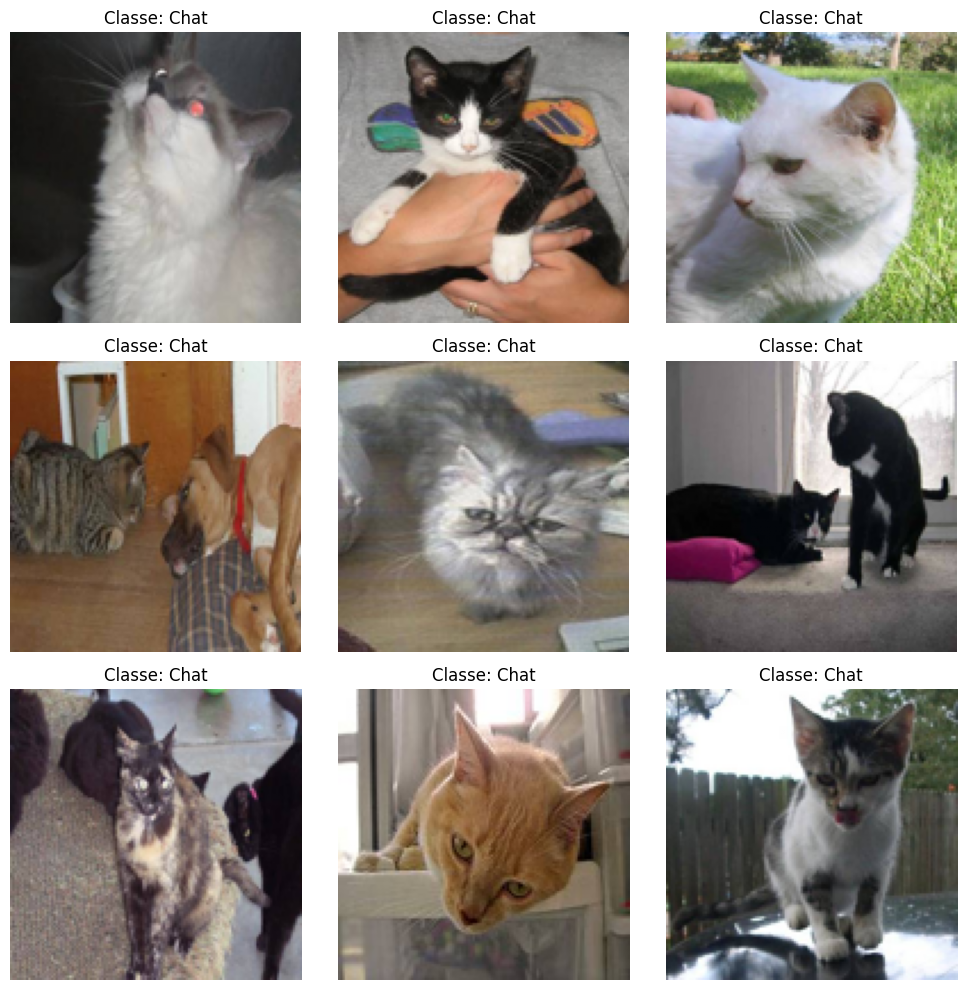

In [6]:
import matplotlib.pyplot as plt
   
   # Afficher quelques images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(X_train[i])
    plt.title(f"Classe: {'Chat' if y_train[i]==0 else 'Chien'}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [99]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
from tensorflow.keras.regularizers import l2

In [8]:

# Avant le modèle.fit()
data_augmentation = Sequential([
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomFlip("horizontal"),
])




# Création du modèle CNN avec explications
model = Sequential([
    # data_augmentation,
    # Première couche de convolution
    # 32 : nombre de filtres (détecteurs de caractéristiques)
    # (3, 3) : taille de la fenêtre de convolution
    # activation='relu' : fonction d'activation qui garde les valeurs positives
    # input_shape : forme de nos images (hauteur, largeur, canaux)
    Conv2D(16, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01), input_shape=(128, 128, 3)),
    # Réduction de la dimension spatiale par 2
    MaxPooling2D(2, 2),
    tf.keras.layers.BatchNormalization(),

    
    # Deuxième couche de convolution : plus de filtres pour détecter des motifs plus complexes
    Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01),),
    MaxPooling2D(2, 2),
    tf.keras.layers.BatchNormalization(),

     
    # Troisième couche de convolution : encore plus de filtres
    # Conv2D(64, (3, 3), activation='relu',  padding='same',  kernel_regularizer=l2(0.01), ),
    # MaxPooling2D(2, 2),
    # tf.keras.layers.BatchNormalization(),
    # Aplatissement : transformation de la matrice 3D en vecteur 1D
    Flatten(),
    
    # Couche dense avec 512 neurones
    # C'est ici que se fait la "prise de décision"
    Dense(64, activation='relu', kernel_regularizer=l2(0.1)),
    
    # Dropout : désactive aléatoirement 50% des neurones pendant l'entraînement
    # Cela évite le surapprentissage
    Dropout(0.4),
    
    # Couche de sortie : 1 neurone avec sigmoid pour la classification binaire
    # sigmoid donne une probabilité entre 0 (chat) et 1 (chien)
    Dense(1, activation='sigmoid')
])
# Affichage de l'architecture du modèle
# model.summary()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00007)

# Configuration du modèle
model.compile(
    optimizer=optimizer,  # Algorithme d'optimisation adaptatif
    loss='binary_crossentropy',  # Fonction de perte pour classification binaire
    metrics=['accuracy']  # Mesure de la précision
)
#voir ce qui peut etre intéréssant à approfondir aux niveaux de l'optimizer et des metrics aussi

2025-03-06 19:44:19.265207: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-06 19:44:19.266047: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


2025-03-06 19:44:53.793789: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 971440128 exceeds 10% of free system memory.


Epoch 1/30
155/155 [==============================] - ETA: 0s - loss: 11.0868 - accuracy: 0.6086

2025-03-06 19:45:29.992058: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 243007488 exceeds 10% of free system memory.


155/155 [==============================] - 31s 177ms/step - loss: 11.0868 - accuracy: 0.6086 - val_loss: 9.1917 - val_accuracy: 0.1424
Epoch 2/30
155/155 [==============================] - 24s 156ms/step - loss: 7.3040 - accuracy: 0.7173 - val_loss: 7.3599 - val_accuracy: 0.1149
Epoch 3/30
155/155 [==============================] - 22s 142ms/step - loss: 5.0777 - accuracy: 0.7675 - val_loss: 4.5415 - val_accuracy: 0.5332
Epoch 4/30
155/155 [==============================] - 22s 140ms/step - loss: 3.5880 - accuracy: 0.8085 - val_loss: 3.3497 - val_accuracy: 0.6028
Epoch 5/30
155/155 [==============================] - 22s 141ms/step - loss: 2.5886 - accuracy: 0.8249 - val_loss: 2.4530 - val_accuracy: 0.6610
Epoch 6/30
155/155 [==============================] - 22s 143ms/step - loss: 1.9184 - accuracy: 0.8500 - val_loss: 1.7092 - val_accuracy: 0.8430
Epoch 7/30
155/155 [==============================] - 22s 139ms/step - loss: 1.4753 - accuracy: 0.8707 - val_loss: 1.4486 - val_accuracy: 0.

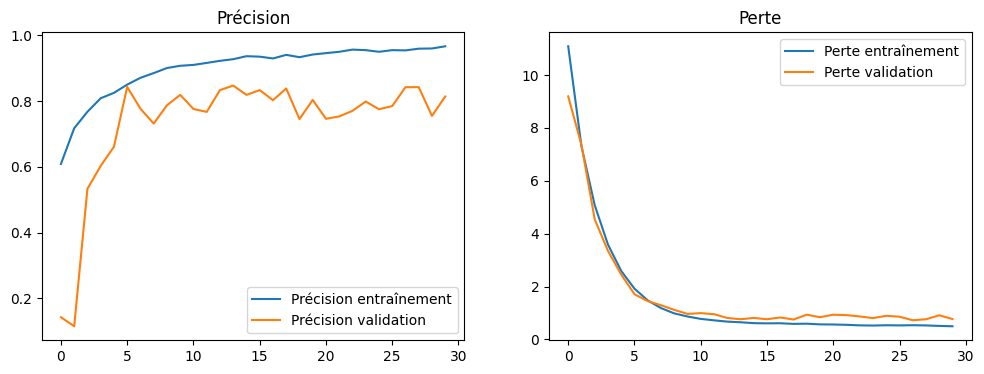

In [9]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Entraînement du modèle
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,  # Utilise 20% des données d'entraînement pour la validation
    verbose=1
)

# Visualisation des résultats
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Précision entraînement')
plt.plot(epochs_range, val_acc, label='Précision validation')
plt.legend()
plt.title('Précision')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Perte entraînement')
plt.plot(epochs_range, val_loss, label='Perte validation')
plt.legend()
plt.title('Perte')

plt.show()

In [ ]:
# Évaluation sur les données de test
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"\nPrécision sur les données de test: {test_accuracy:.4f}")

# Prédictions sur quelques images de test
predictions = model.predict(X_test[:5])

# Affichage des prédictions
plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(X_test[i])
    pred = 'Chien' if predictions[i] > 0.5 else 'Chat'
    true = 'Chien' if y_test[i] == 1 else 'Chat'
    plt.title(f'Pred: {pred}\nVrai: {true}')
    plt.axis('off')
plt.show()

# Sauvegarde du modèle
# model.save('cat_vs_dog_model.h5')